In [1]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

import tsunamibayes as tb
from tsunamibayes.fault import ReferenceCurveFault, BaseFault
from tsunamibayes.multifault import MultiFault
from tsunamibayes.utils import bearing, haversine

# Get the data we need to try gaussian process interpolation

In [2]:
def convert_lat_lon(lat, lon):
    """Converts latitude and longitude from strings to decimals.
    Proper string form: '8-17-43.21S', '118-43-42.00E' etc.
    """
    latitude = sum(float(x) / 60 ** n for n, x in enumerate(lat[:-1].split('-')))  * (1 if 'N' == lat[-1] else -1)
    longitude = sum(float(x) / 60 ** n for n, x in enumerate(lon[:-1].split('-'))) * (1 if 'E' == lon[-1] else -1)
    return latitude, longitude

In [3]:
#pass in data as arrays

#small referes to 5.0-5.9 magnitude
flores_small = pd.read_excel('./1820_fault_data/flores_trench5.0-5.9_filtered.xlsx')
flores_lat_small = pd.DataFrame(flores_small, columns = ['lat(deg S)']).to_numpy().flatten()
flores_long_small = pd.DataFrame(flores_small, columns = ['log (deg E)']).to_numpy().flatten()
flores_mag_small = pd.DataFrame(flores_small, columns = ['Magnitude']).to_numpy().flatten()
flores_depth_small = pd.DataFrame(flores_small, columns = ['Depth km']).to_numpy().flatten()
flores_plate_boundary_small = pd.DataFrame(flores_small, columns = ['Distance from plate boundary km (estimated)']).to_numpy().flatten()
flores_dist_ratio_small = pd.DataFrame(flores_small, columns = ['Calculated distance ratio (depth/TAN(Dip))']).to_numpy().flatten()
flores_strike_small = pd.DataFrame(flores_small, columns = ['Stike']).to_numpy().flatten()
flores_dip_small = pd.DataFrame(flores_small, columns = ['Dip']).to_numpy().flatten()
flores_rake_small = pd.DataFrame(flores_small, columns = ['Rake']).to_numpy().flatten()

#large refers to 6.0-7.2 magnitude
flores_large = pd.read_excel('./1820_fault_data/flores-trench6-7.2_filtered.xlsx')
flores_lat_large = pd.DataFrame(flores_large, columns = ['Lat (S & degree):']).to_numpy().flatten()
flores_long_large = pd.DataFrame(flores_large, columns = ['Long (E & degree):']).to_numpy().flatten()
flores_mag_large = pd.DataFrame(flores_large, columns = ['Magnitude']).to_numpy().flatten()
flores_depth_large = pd.DataFrame(flores_large, columns = ['Depth km']).to_numpy().flatten()
flores_plate_boundary_large = pd.DataFrame(flores_large, columns = ['Distance from plate boundary km (estimated)']).to_numpy().flatten()
flores_dist_ratio_large = pd.DataFrame(flores_large, columns = ['Calculated distance ratio (depth/TAN(Dip))']).to_numpy().flatten()
flores_strike_large = pd.DataFrame(flores_large, columns = ['Stike']).to_numpy().flatten()
flores_dip_large = pd.DataFrame(flores_large, columns = ['Dip']).to_numpy().flatten()
flores_rake_large = pd.DataFrame(flores_large, columns = ['Rake']).to_numpy().flatten()


dataflores_large = [] #a list will be returned of lat and long
for i in range(len(flores_lat_large)):
    dataflores_large.append(convert_lat_lon(flores_lat_large[i], flores_long_large[i]))
    
dataflores_small = [] #a list will be returned of lat and long
for i in range(len(flores_lat_small)):
    dataflores_small.append(convert_lat_lon(flores_lat_small[i], flores_long_small[i]))
    
a_dataflores_large = np.array(dataflores_large) #convert list to array
a_dataflores_lat_large = a_dataflores_large[:,0]
a_dataflores_long_large = a_dataflores_large[:,1]

a_dataflores_small = np.array(dataflores_small) #convert list to array
a_dataflores_lat_small = a_dataflores_small[:,0]
a_dataflores_long_small = a_dataflores_small[:,1]

In [4]:
lats = np.append(a_dataflores_lat_large, a_dataflores_lat_small)
lons = np.append(a_dataflores_long_large, a_dataflores_long_small)
depths = np.append(flores_depth_large, flores_depth_small)
dips = np.append(flores_dip_large, flores_dip_small)
strikes = np.append(flores_strike_large, flores_strike_small)
rakes = np.append(flores_rake_large, flores_rake_small)

In [5]:
# %matplotlib notebook

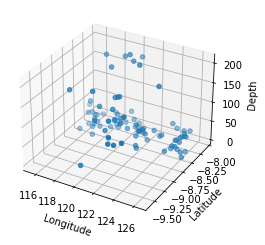

In [6]:
fig_3d = plt.figure()
ax = plt.subplot(projection='3d')
ax.scatter(lons, lats, depths)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth')
plt.show()

# Perform Gaussian Process Interpolation on the depths

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [8]:
X = np.vstack([lats, lons]).T
y = 1000*depths.copy() # change to meters

# If we have a specific covariance that we believe in, we could use that as
# the kernel for the GaussianProcessRegressor, but I don't know of one.
# The best one I can think of is to have high covariances for nearby points and 
# lower ones for far away points, perhaps at a quadratic rate.
gpr = GaussianProcessRegressor(n_restarts_optimizer=12)

# Fit to data using Maximum Likelihood Estimation of the parameters
gpr.fit(X, y)


flores_lats = np.linspace(-14, -3, 200)
flores_lons = np.linspace(110, 132, 200)

/Users/paskett/anaconda3/envs/tay/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


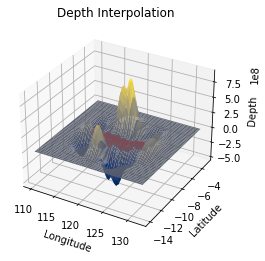

In [9]:
Xplot, Yplot = np.meshgrid(flores_lons,flores_lats)
Zplot, sigma = gpr.predict(np.vstack([Yplot.flatten(), Xplot.flatten()]).T, return_std=True)
Zplot = Zplot.reshape(Xplot.shape)
sigma = sigma.reshape(Xplot.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
ax.plot_surface(Xplot,Yplot,Zplot,cmap='cividis')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth')
plt.title('Depth Interpolation')
plt.show()

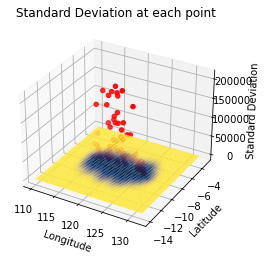

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
ax.plot_surface(Xplot,Yplot,sigma,cmap='cividis')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Standard Deviation')
plt.title('Standard Deviation at each point')
plt.show()

/Users/paskett/anaconda3/envs/tay/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


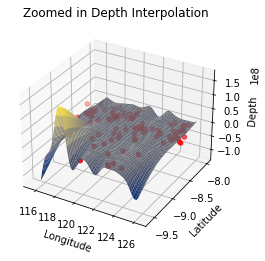

In [11]:
zoomed_flores_lats = np.linspace(-9.6, -8.0, 1000)
zoomed_flores_lons = np.linspace(116, 126, 1000)
Xplot, Yplot = np.meshgrid(zoomed_flores_lons,zoomed_flores_lats)
Zplot, sigma = gpr.predict(np.vstack([Yplot.flatten(), Xplot.flatten()]).T, return_std=True)
Zplot = Zplot.reshape(Xplot.shape)
sigma = sigma.reshape(Xplot.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
ax.plot_surface(Xplot,Yplot,Zplot,cmap='cividis')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth')
plt.title('Zoomed in Depth Interpolation')
plt.show()

## Let's try to fix some of the weirdly deep interpolations.

We have some problems with super deep areas (greater than 1,000 km), which are appearing for no apparent reason. 
Changing the covariance matrix and/or dropping data points that are "too deep" may help us avoid this. 

In [81]:
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, WhiteKernel, DotProduct
%matplotlib notebook

In [24]:
X = np.vstack([lats, lons]).T
y = depths.copy() # Don't change to meters.
to_interp = y < 25 # Drop everything deeper than 25km.
X = X[to_interp]
y = y[to_interp]

In [31]:
len(X)

30

In [30]:
np.sum(depths < 25)

30

In [25]:
# This kernel gets us the covariance matrix when we plug in our test data.
ker = RBF() #DotProduct() +  #+ WhiteKernel(noise_level=100)#RBF()

gpr2 = GaussianProcessRegressor(
    n_restarts_optimizer=1, 
    normalize_y=True, # Sets the mean to the sample mean
    kernel=ker,
    #alpha=1e-8,
    random_state=42
)

# Fit to data using Maximum Likelihood Estimation of the parameters
gpr2.fit(X, y)
Zplot, sigma = gpr2.predict(np.vstack([Yplot.flatten(), Xplot.flatten()]).T, return_std=True)
Zplot = Zplot.reshape(Xplot.shape)
sigma = sigma.reshape(Xplot.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
ax.plot_surface(Xplot,Yplot,Zplot,cmap='cividis')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth')
plt.title('Zoomed in Depth Interpolation')
plt.show()

<IPython.core.display.Javascript object>

In [18]:
gpr2.score(X,y)

1.0

In [19]:
gpr2.score?

# Add mean values throughout the space as interpolant values

In [62]:
X = np.vstack([lats, lons]).T
y = depths.copy() # Change to meters.
to_interp = y < 25 # Drop everything deeper than 25km.
X = X[to_interp]
y = y[to_interp]
mean_val = y.mean()

# X = np.vstack([X, [Yplot.max(), Xplot.max()]])
# y = np.append(y, mean_val)
# X = np.vstack([X, [Yplot.min(), Xplot.max()]])
# y = np.append(y, mean_val)
# X = np.vstack([X, [Yplot.max(), Xplot.min()]])
# y = np.append(y, mean_val)
# X = np.vstack([X, [Yplot.min(), Xplot.min()]])
# y = np.append(y, mean_val)

# X = np.vstack([X, np.vstack([Yplot[:,0][1::20], Xplot[:,-1][1::20]]).T])
# y = np.append(y, np.ones((25,))*mean_val)
# X = np.vstack([X, np.vstack([Yplot[:,0][1::20], Xplot[:,0][1::20]]).T])
# y = np.append(y, np.ones((25,))*mean_val)
# X = np.vstack([X, np.vstack([Yplot[:,-1][1::20], Xplot[:,0][1::20]]).T])
# y = np.append(y, np.ones((25,))*mean_val)
# X = np.vstack([X, np.vstack([Yplot[0][1::20], Xplot[:,0][1::20]]).T])
# y = np.append(y, np.ones((25,))*mean_val)

<IPython.core.display.Javascript object>


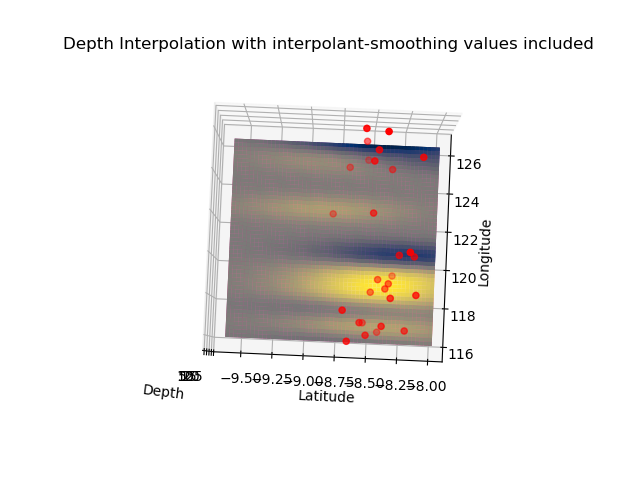

In [107]:
# This kernel gets us the covariance matrix when we plug in our test data.
ker = 1*RBF(length_scale=0.00001) #* WhiteKernel(noise_level=15)

gpr2 = GaussianProcessRegressor(
    n_restarts_optimizer=10, 
    normalize_y=True, # Sets the mean to the sample mean
    kernel=ker,
    alpha=7
)

# Fit to data using Maximum Likelihood Estimation of the parameters
gpr2.fit(X, y)
Zplot, sigma = gpr2.predict(np.vstack([Yplot.flatten(), Xplot.flatten()]).T, return_std=True)
Zplot = Zplot.reshape(Xplot.shape)
sigma = sigma.reshape(Xplot.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
ax.plot_surface(Xplot,Yplot,Zplot,cmap='cividis')
ax.plot_surface(Xplot,Yplot,Zplot + sigma,cmap='magma')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth')
plt.title('Depth Interpolation with interpolant-smoothing values included')
plt.show()

In [101]:
np.allclose(sigma, 0.01688379)

True

In [72]:
WhiteKernel?

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

<IPython.core.display.Javascript object>


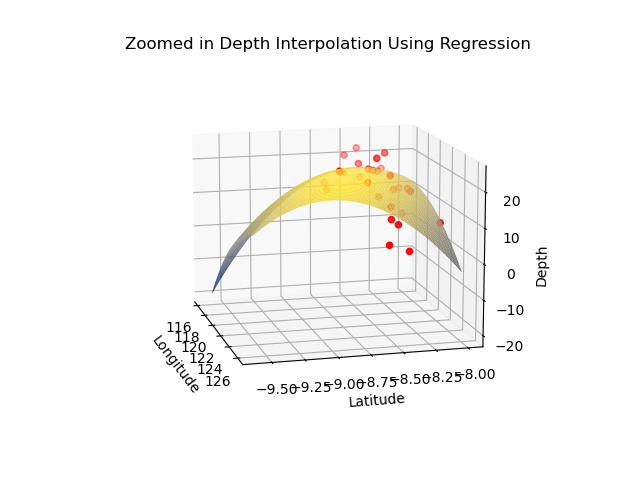

In [84]:
reg = LinearRegression().fit(X, y)
degree = 3
model = make_pipeline(PolynomialFeatures(degree), Ridge())
model.fit(X, y)
Zplot = model.predict(np.vstack([Yplot.flatten(), Xplot.flatten()]).T)
#Zplot = reg.predict(np.vstack([Yplot.flatten(), Xplot.flatten()]).T)
Zplot = Zplot.reshape(Xplot.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
ax.plot_surface(Xplot,Yplot,Zplot,cmap='cividis')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth')
plt.title('Zoomed in Depth Interpolation Using Regression')
plt.show()

In [ ]:
X = np.vstack([lats, lons]).T
y = dips.copy()
X = X[to_interp]
y = y[to_interp]

# This kernel gets us the covariance matrix when we plug in our test data.
ker = RationalQuadratic(length_scale=1000)

gpr2 = GaussianProcessRegressor(
    n_restarts_optimizer=12, 
    normalize_y=True, # Sets the mean to the sample mean
    #kernel=ker,
    #alpha=1e-8
)

# Fit to data using Maximum Likelihood Estimation of the parameters
gpr2.fit(X, y)
Zplot, sigma = gpr2.predict(np.vstack([Yplot.flatten(), Xplot.flatten()]).T, return_std=True)
Zplot = Zplot.reshape(Xplot.shape)
sigma = sigma.reshape(Xplot.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
ax.plot_surface(Xplot,Yplot,Zplot,cmap='cividis')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Dip')
plt.title('Dip Interpolation')
plt.show()



In [ ]:
X = np.vstack([lats, lons]).T
y = strikes.copy()
X = X[to_interp]
y = y[to_interp]

# This kernel gets us the covariance matrix when we plug in our test data.
ker = RationalQuadratic(length_scale=1000)

gpr2 = GaussianProcessRegressor(
    n_restarts_optimizer=12, 
    normalize_y=True, # Sets the mean to the sample mean
    #kernel=ker,
    #alpha=1e-8
)

# Fit to data using Maximum Likelihood Estimation of the parameters
gpr2.fit(X, y)
Zplot, sigma = gpr2.predict(np.vstack([Yplot.flatten(), Xplot.flatten()]).T, return_std=True)
Zplot = Zplot.reshape(Xplot.shape)
sigma = sigma.reshape(Xplot.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
ax.plot_surface(Xplot,Yplot,Zplot,cmap='cividis')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Strike')
plt.title('Strike Interpolation')
plt.show()

In [ ]:
X = np.vstack([lats, lons]).T
y = rakes.copy()
X = X[to_interp]
y = y[to_interp]

# This kernel gets us the covariance matrix when we plug in our test data.
ker = RationalQuadratic(length_scale=1000)

gpr2 = GaussianProcessRegressor(
    n_restarts_optimizer=12, 
    normalize_y=True, # Sets the mean to the sample mean
    #kernel=ker,
    #alpha=1e-8
)

# Fit to data using Maximum Likelihood Estimation of the parameters
gpr2.fit(X, y)
Zplot, sigma = gpr2.predict(np.vstack([Yplot.flatten(), Xplot.flatten()]).T, return_std=True)
Zplot = Zplot.reshape(Xplot.shape)
sigma = sigma.reshape(Xplot.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot original Flores-associated lat/lon depths
ax.scatter(X[:,1], X[:,0], y, c='r', s=20)
ax.plot_surface(Xplot,Yplot,Zplot,cmap='cividis')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Rake')
plt.title('Rake Interpolation')
plt.show()